### PID control of `Snapbot`

In [1]:
import sys,mujoco
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')
from mujoco_parser import *
from slider import *
from utility import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


#### Parse `Snapbot`

In [2]:
xml_path = '../asset/snapbot/scene_snapbot.xml'
env = MuJoCoParserClass(name='Snapbot',rel_xml_path=xml_path,verbose=True)

name:[Snapbot] dt:[0.002] HZ:[500]
n_qpos:[25] n_qvel:[24] n_qacc:[24] n_ctrl:[8]

n_body:[24]
 [0/24] [world] mass:[0.00]kg
 [1/24] [torso] mass:[0.24]kg
 [2/24] [Camera_module_1] mass:[0.06]kg
 [3/24] [Camera_module_2] mass:[0.06]kg
 [4/24] [Leg_module_1_1] mass:[0.06]kg
 [5/24] [Leg_module_1_2] mass:[0.08]kg
 [6/24] [Leg_module_1_3] mass:[0.02]kg
 [7/24] [Leg_module_1_4] mass:[0.01]kg
 [8/24] [Leg_module_1_4bar] mass:[0.01]kg
 [9/24] [Leg_module_2_1] mass:[0.06]kg
 [10/24] [Leg_module_2_2] mass:[0.08]kg
 [11/24] [Leg_module_2_3] mass:[0.02]kg
 [12/24] [Leg_module_2_4] mass:[0.01]kg
 [13/24] [Leg_module_2_4bar] mass:[0.01]kg
 [14/24] [Leg_module_4_1] mass:[0.06]kg
 [15/24] [Leg_module_4_2] mass:[0.08]kg
 [16/24] [Leg_module_4_3] mass:[0.02]kg
 [17/24] [Leg_module_4_4] mass:[0.01]kg
 [18/24] [Leg_module_4_4bar] mass:[0.01]kg
 [19/24] [Leg_module_5_1] mass:[0.06]kg
 [20/24] [Leg_module_5_2] mass:[0.08]kg
 [21/24] [Leg_module_5_3] mass:[0.02]kg
 [22/24] [Leg_module_5_4] mass:[0.01]kg
 [

#### PID controller

In [3]:
pid = PID_ControllerClass(
    name = 'PID',dim = env.n_ctrl,
    k_p = 150.0, k_i = 0.1, k_d = 5.0,
    out_min = env.ctrl_ranges[:,0],
    out_max = env.ctrl_ranges[:,1],
    ANTIWU  = True)
print ("Ready.")

Ready.


In [4]:
# Modify floor friction priority
env.model.geom('floor').priority = 1 # 0=>1
print ("Floor priority:%s"%(env.model.geom('floor').priority))

Floor priority:[1]


#### Loop

In [5]:
# Buffer
max_tick    = 5000
t_list      = np.zeros(shape=(max_tick))
x_trgt_list = np.zeros(shape=(max_tick,env.n_ctrl))
qpos_list   = np.zeros(shape=(max_tick,env.n_ctrl))
qvel_list   = np.zeros(shape=(max_tick,env.n_ctrl))
torque_list = np.zeros(shape=(max_tick,env.n_ctrl))
# Loop
env.reset(step=True)
env.init_viewer(distance=3.0,lookat=[0,0,0])
pid.reset()
while env.is_viewer_alive() and (env.tick < max_tick):
    # Change PID target
    if (env.tick%500) == 0: 
        q_trgt = np.radians(50*(-1.0+2.0*np.random.rand(env.n_ctrl)))

    # PID controller
    qpos = env.data.qpos[env.ctrl_qpos_idxs]
    qvel = env.data.qpos[env.ctrl_qvel_idxs]
    pid.update(x_trgt=q_trgt,t_curr=env.get_sim_time(),x_curr=qpos,VERBOSE=False)

    # Update
    torque = pid.out()
    env.step(ctrl=torque) # update
    contacts = np.zeros(env.n_sensor)
    idxs = np.where(env.get_sensor_values(sensor_names=env.sensor_names)>0.2)[0]
    contacts[idxs] = 1.0 # 0:non-contact, 1:contact

    # Append
    t_list[env.tick-1]        = env.get_sim_time()
    x_trgt_list[env.tick-1,:] = pid.x_trgt
    qpos_list[env.tick-1,:]   = qpos
    qvel_list[env.tick-1,:]   = qvel
    torque_list[env.tick-1,:] = torque
    
    # Render
    if env.loop_every(tick_every=20):
        env.plot_T()
        for c_idx in np.where(contacts==1)[0]:
            sensor_name = env.sensor_names[c_idx]
            env.plot_sphere(p=env.get_p_sensor(sensor_name),r=0.02,rgba=(0,0,1,0.5))
        env.plot_contact_info()
        env.render()
# Close viewer
env.close_viewer()        
print ("Done.")

Done.


#### Plot tracking performance

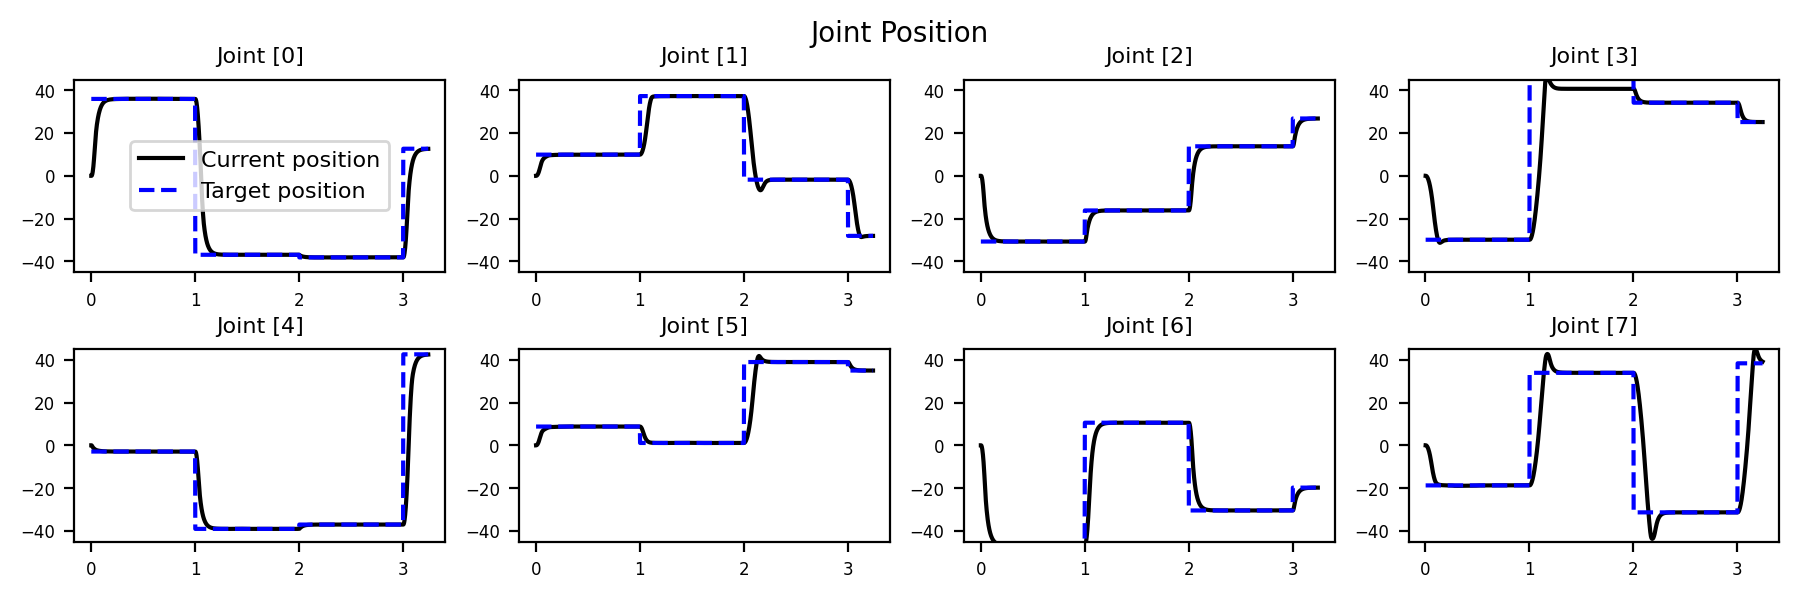

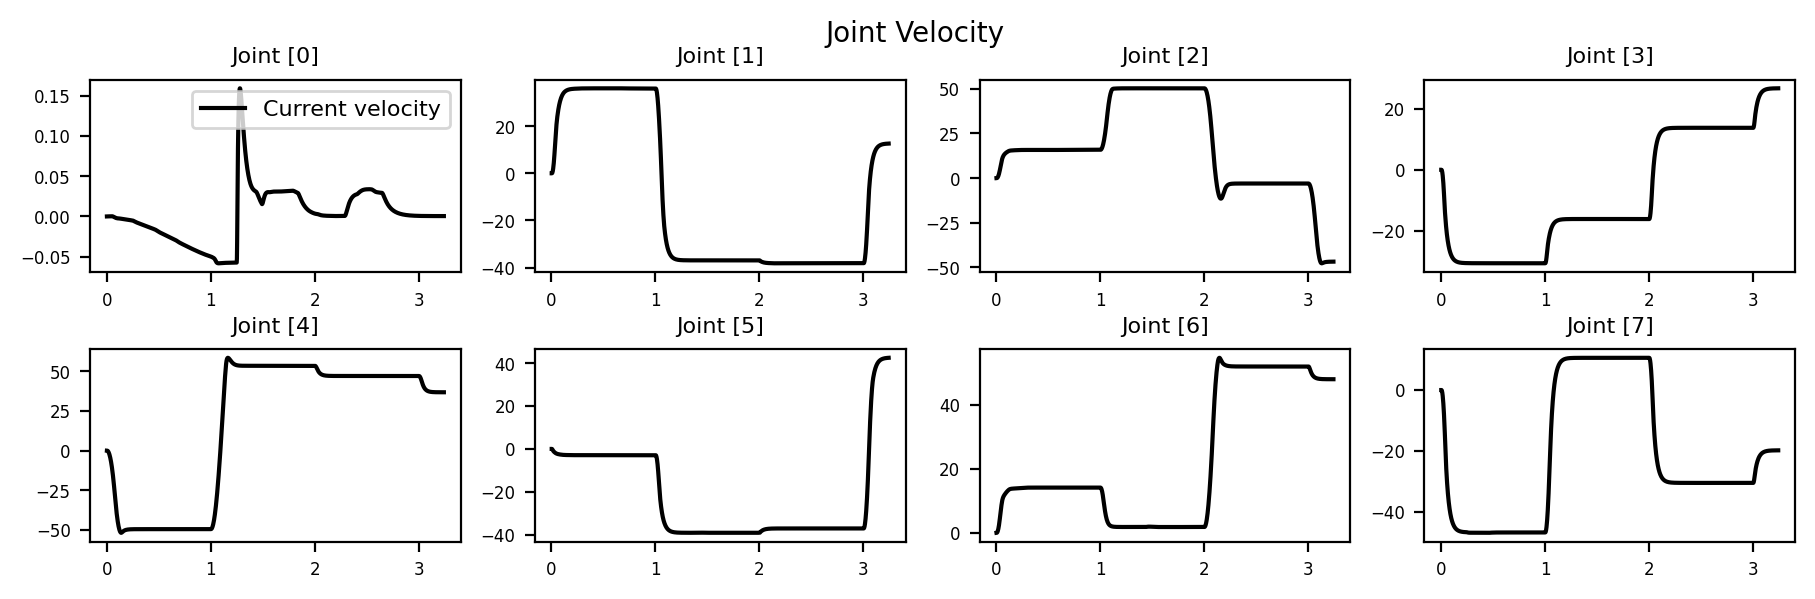

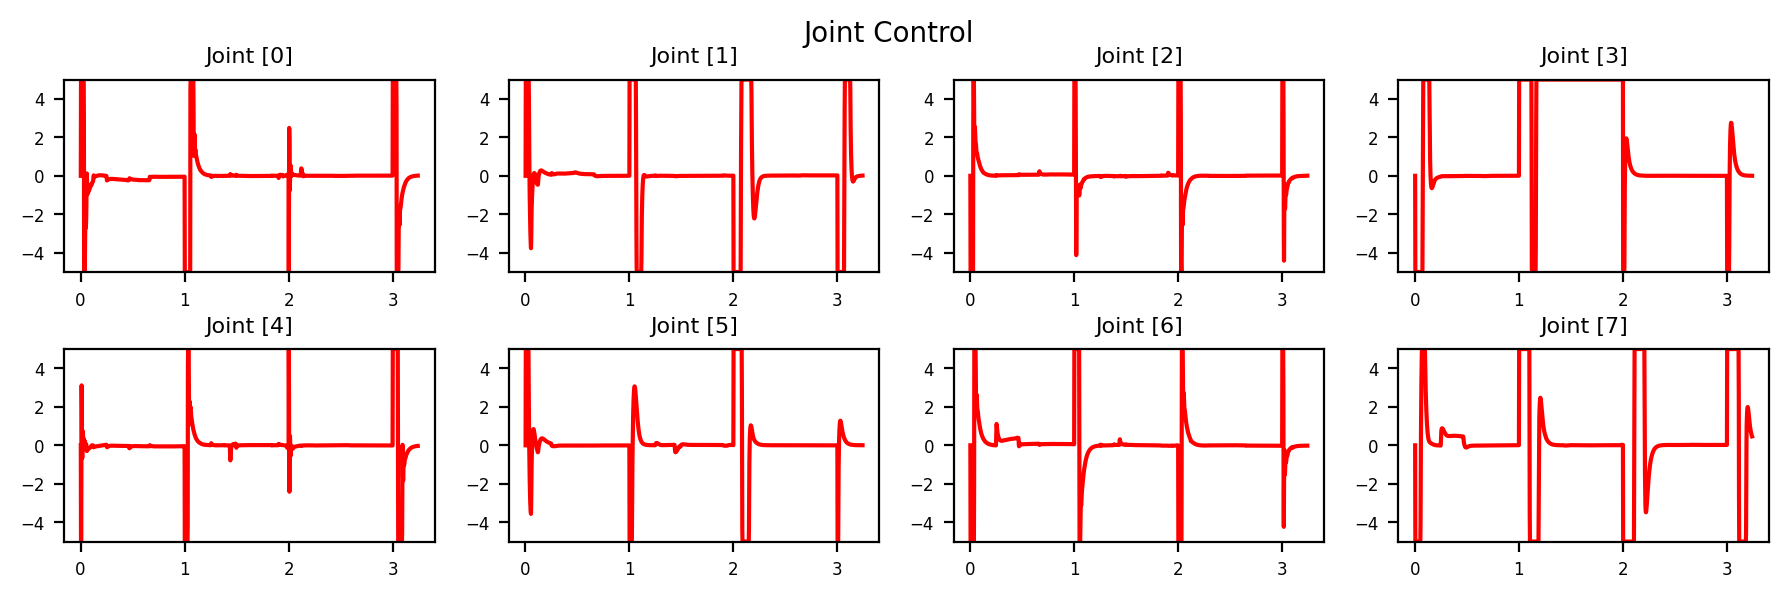

In [6]:
# Plot target and current joint position
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=False,sharey=False,figsize=(11,3))
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Joint Position", fontsize=10)
for a_idx,ax in enumerate(axs.ravel()):
    ax.plot(t_list[:env.tick],np.degrees(qpos_list[:env.tick,a_idx]),
            '-',color='k',label='Current position')
    ax.plot(t_list[:env.tick],np.degrees(x_trgt_list[:env.tick,a_idx]),
            '--',color='b',label='Target position')
    ax.set_ylim(bottom=-45,top=45)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=8)
    if a_idx == 0: ax.legend(fontsize=8)
plt.show()

# Plot joint velocity
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=False,sharey=False,figsize=(11,3))
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Joint Velocity", fontsize=10)
for a_idx,ax in enumerate(axs.ravel()):
    ax.plot(t_list[:env.tick],np.degrees(qvel_list[:env.tick,a_idx]),
            '-',color='k',label='Current velocity')
    # ax.set_ylim(bottom=-45,top=45)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=8)
    if a_idx == 0: ax.legend(fontsize=8)
plt.show()

# Plot control output
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=False,sharey=False,figsize=(11,3))
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Joint Control", fontsize=10)
for a_idx,ax in enumerate(axs.ravel()):
    ax.plot(t_list[:env.tick],torque_list[:env.tick,a_idx],color='r')
    ax.set_ylim(bottom=env.ctrl_ranges[a_idx,0],top=env.ctrl_ranges[a_idx,1])
    ax.set_title('Joint [%d]'%(a_idx),fontsize=8)
plt.show()